In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from rasterio.windows import Window
from rasterio.transform import xy
import os
import geopandas as gpd
import glob
import random
import pandas as pd
from rembg import remove
import cv2
import time

## Fusion imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.models import Model




OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
path1 = os.path.abspath('../')
path_ATL03 = os.path.join(path1, "IS2_LSTM")
path_s2 = os.path.join(path1, "S2_tif")
path_csv = os.path.join(path1, "csv")
path_before_training = os.path.join(path1, "Before_training")
print(path_s2)

/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/S2_tif


# Important functions

In [13]:
def color_segmentation(img):
    # Get a "mask" over the image for each pixel
    # if a pixel's color is between the lower and upper white, its mask is 1
    # Otherwise, the pixel's mask is 0
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    lower_ice = (0, 0, 205)#(127, 7, 94) #increase v to specify ow
    upper_ice = (185, 255, 255)#(147, 53, 232) #increase h to specify si
    mask_ice = cv2.inRange(hsv_img, lower_ice, upper_ice)
    
    lower_tice = (0, 0, 31)#(127, 7, 94) #increase v to specify ow
    upper_tice = (185, 255, 204)#(147, 53, 232) #increase h to specify si
    mask_tice = cv2.inRange(hsv_img, lower_tice, upper_tice)
    
    lower_water = (0, 0, 0)#(127, 7, 94) #increase v to specify ow
    upper_water = (185, 255, 30)#(147, 53, 232) #increase h to specify si
    mask_water = cv2.inRange(hsv_img, lower_water, upper_water)
    
    # duplicate the image
    seg_img = img.copy()
    #color each masked portion
    seg_img[mask_ice == 255] = [255, 0, 0]
    seg_img[mask_tice == 255] = [0, 0, 255]
    seg_img[mask_water == 255] = [0, 255, 0]
    
    #seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
    
    return seg_img

def shadow_cloud_removal(ori):

    ### seperate open water
    lower_water = (0, 0, 0)
    upper_water = (185, 255, 30)
    hsv_img = cv2.cvtColor(ori, cv2.COLOR_RGB2HSV)
    mask_water = (cv2.inRange(hsv_img, lower_water, upper_water))

    # duplicate the image
    without_water_img = ori.copy()
    without_water_img[mask_water == 255] = [255, 255, 255]
    #plot_image(ori, water_img)

    #img = cv2.imread('s2_vis_2.png',cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(without_water_img, cv2.COLOR_RGB2GRAY)

    dilated_img = cv2.dilate(img, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 155)
    diff_img = 255 - cv2.absdiff(img, bg_img)

    ret2, outs2 = cv2.threshold(src = diff_img, thresh = 0, maxval = 255, type = cv2.THRESH_OTSU+cv2.THRESH_BINARY)
    diff_img2 = cv2.bitwise_and(diff_img, outs2)

    norm_img = cv2.normalize(diff_img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    _, thr_img = cv2.threshold(norm_img, 235, 0, cv2.THRESH_TRUNC)
    thr_img = cv2.normalize(thr_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

    ### seperate thin and old ice
    old_thin_ice = cv2.cvtColor(thr_img,cv2.COLOR_GRAY2RGB)
    hsv_img = cv2.cvtColor(old_thin_ice, cv2.COLOR_RGB2HSV)

    lower_tice = (0, 0, 0)
    upper_tice = (185, 255, 204)
    mask_tice = cv2.inRange(hsv_img, lower_tice, upper_tice)

    lower_ice = (0, 0, 205)
    upper_ice = (185, 255, 255)
    mask_ice = cv2.inRange(hsv_img, lower_ice, upper_ice)
    mask_ice = cv2.bitwise_xor(mask_water, mask_ice)
    #plot_image3(mask_water, mask_tice, mask_ice)

    # duplicate the image
    shadow_free = old_thin_ice.copy()
    #color each masked portion
    shadow_free[mask_ice == 255] = [255, 255, 255]
    shadow_free[mask_tice == 255] = [155, 155, 155]
    shadow_free[mask_water == 255] = [0, 0, 0]
    shadow_free = cv2.cvtColor(shadow_free, cv2.COLOR_BGR2RGB)
    #plot_image(shadow_free, ori)

    #segmentation
    #img = cv2.cvtColor(water_img,cv2.COLOR_GRAY2RGB)
    seg_img = color_segmentation(ori)
    #plot_image(ori, seg_img, title_1 = "Original Image", title_2 = "Segmented original image")

    #final = cv2.cvtColor(shadow_free,cv2.COLOR_GRAY2RGB)
    seg_res = color_segmentation(shadow_free)
    #gray = cv2.cvtColor(seg_res,cv2.COLOR_RGB2GRAY)
    #plot_image(shadow_free, seg_res, title_1 = "Shadow free Image", title_2 = "Segmented shadow free image")
    
    #return seg_img, shadow_free, seg_res
    return seg_res


def rgba2rgb( rgba, background=(0,0,0)):
    row, col, ch = rgba.shape
    if ch == 3:
        return rgba
    assert ch == 4, 'RGBA image has 4 channels.'
    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    a = np.asarray( a, dtype='float32' ) / 255.0
    R, G, B = background
    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B
    return np.asarray( rgb, dtype='uint8' )

In [4]:
# Define file paths
tiff_files = ['s2_vis_00_20191103T183459_20191103T183502_T05CMR.tif', 's2_vis_01_20191103T183459_20191103T183502_T05CMS.tif']


# Get list of TIFF files
tiff_files = sorted(glob.glob(os.path.join(path_s2, "*.tif")))

# Get list of CSV files
csv_files = sorted(glob.glob(os.path.join(path_csv, "*.csv")))

# Select two random CSV files
selected_csv_files = random.sample(csv_files, 2)

# ATL03 to S2 mapping file
atl03_to_s2_mapping_file = pd.read_csv(os.path.join(path1, "ATL03_S2_2019-11-01_2019-11-30_ross.csv"))


In [35]:
# Show 32x32 Grid Lines (Work on first two files only)
def show_32x32_grid_lines_on_tif_files():
    for file in tiff_files[:2]:
        with rasterio.open(file) as img:
            width, height = img.width, img.height
            transform = img.transform

            # Generate grid lines
            x_coords = np.linspace(0, width, 33)
            y_coords = np.linspace(0, height, 33)

            # Plot grid lines
            plt.figure(figsize=(10, 10))
            plt.imshow(img.read(1), cmap='gray')
            for x in x_coords:
                plt.axvline(x, color='red', linewidth=0.5)
            for y in y_coords:
                plt.axhline(y, color='red', linewidth=0.5)
            plt.title(f'Grid Lines for {os.path.basename(file)}')
            plt.show()


In [6]:

def read_csv_if_exists(file):
    print(file)
    if os.path.exists(file) and os.path.isfile(file):
        return pd.read_csv(file)
    return None

# Function to get coordinates list
def get_coordinates_list(file):
    file = os.path.basename(file)[10:-4]
    general_atl_file_prefix_name = atl03_to_s2_mapping_file[atl03_to_s2_mapping_file['S2_id'] == "COPERNICUS/S2_SR/" + file]['IS2_file'].values[0][:-9]

    df_gt1r = pd.DataFrame()
    df_gt2r = pd.DataFrame()
    df_gt3r = pd.DataFrame()

    alt03_gt1r_file = os.path.join(path_csv, general_atl_file_prefix_name + "gt1r.csv")
    alt03_gt2r_file = os.path.join(path_csv, general_atl_file_prefix_name + "gt2r.csv")
    alt03_gt3r_file = os.path.join(path_csv, general_atl_file_prefix_name + "gt3r.csv")

    df_gt1r = read_csv_if_exists(alt03_gt1r_file)
    df_gt2r = read_csv_if_exists(alt03_gt2r_file)
    df_gt3r = read_csv_if_exists(alt03_gt3r_file)
    df = pd.concat([df_gt1r, df_gt2r, df_gt3r])
    coordinates_list = list(zip(df['lat'], df['lon']))

    return coordinates_list  # List of coordinates

## Images, Grids, coordinates, patches

xs.shape:  (233733120,)
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt1r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt2r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt3r.csv


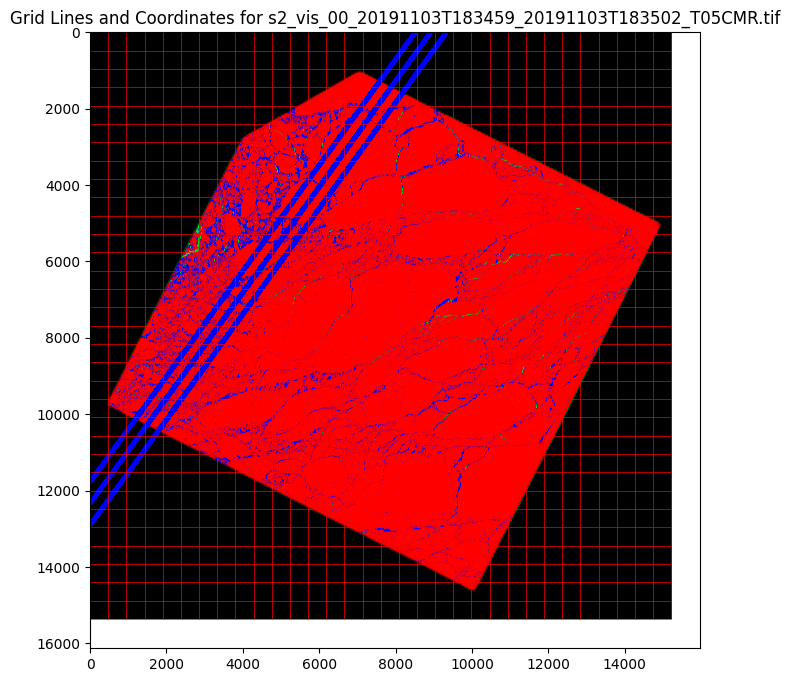

xs.shape:  (233018376,)
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt1r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt2r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt3r.csv


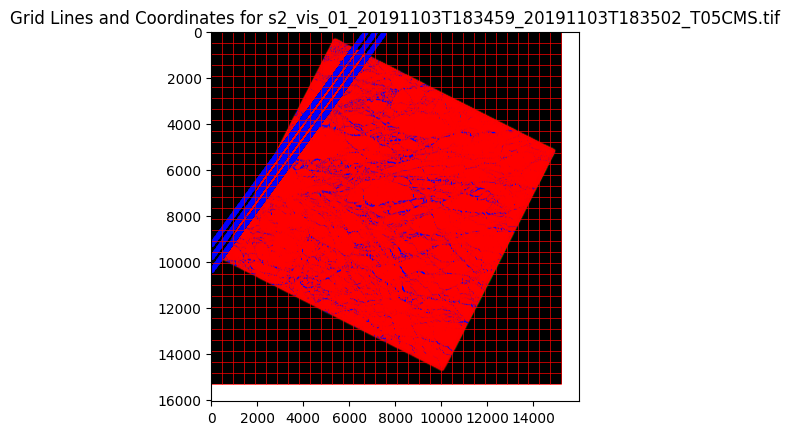

In [38]:
import matplotlib
# matplotlib.use('Agg')  # Use non-interactive backend
# matplotlib.use('TkAgg')
fig, ax = plt.subplots(figsize=(8, 8))

def plot_grid_and_coordinates(file):
    # Open image
    img = rasterio.open(file, crs='EPSG:3976')

    # Read the original image without any processing
    original_img = img.read()
    # Swap axes to get correct orientation (bands last)
    original_img = original_img.swapaxes(0, 2)
    original_img = original_img.swapaxes(0, 1)

    # Get dimensions from original image
    height = original_img.shape[0]
    width = original_img.shape[1]

    # Create coordinate grid
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(img.transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)

    # Convert coordinates to GeoDataFrame
    coordinates_list = get_coordinates_list(file)
    df = pd.DataFrame(coordinates_list, columns=['lat', 'lon'])
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

    # Transform to match the image's CRS
    gdf = gdf.to_crs('epsg:3976')

    # Extract transformed coordinates
    gdf['x'] = gdf.geometry.apply(lambda x: x.x)
    gdf['y'] = gdf.geometry.apply(lambda x: x.y)

    # Filter coordinates
    df = pd.DataFrame(gdf)
    x_min = xs.min()
    x_max = xs.max()
    y_min = ys.min()
    y_max = ys.max()
    df = df[(df["x"] >= x_min) & (df["x"] <= x_max) & 
            (df["y"] >= y_min) & (df["y"] <= y_max)]

    # Map coordinates to pixel indices
    pixel_coords = [img.index(x, y) for x, y in zip(df['x'], df['y'])]

    # Generate grid lines
    x_coords = np.linspace(0, width, 33)
    y_coords = np.linspace(0, height, 33)

    # Plot
    plt.imshow(original_img)  # Plot original image without any processing
    plt.vlines(x_coords, 0, height, color='red', linewidth=0.5)
    plt.hlines(y_coords, 0, width, color='red', linewidth=0.5)
    
    rows, cols = zip(*pixel_coords)
    plt.scatter(cols, rows, color='blue', s=2)
    
    plt.title(f'Grid Lines and Coordinates for {os.path.basename(file)}')
    plt.show()


# Plot grid lines and coordinates for the first two files
for file in tiff_files[:2]:
    plot_grid_and_coordinates(file)

In [17]:
def create_patches_from_coordinates(file):
    img = rasterio.open(file, crs='EPSG:3976')
    raw = img.read(1)
    raw[raw < 0] = 0

    ori = img.read()
    ori[ori < 0] = 0
    ori = ori.swapaxes(0, 1)
    ori = ori.swapaxes(1, 2)

    img_array = shadow_cloud_removal(ori)
    img_array[img_array < 0] = 0

    height = img_array.shape[0]
    width = img_array.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(img.transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)

    coordinates_list = get_coordinates_list(file)
    df = pd.DataFrame(coordinates_list, columns=['lat', 'lon'])
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    gdf = gdf.to_crs('epsg:3976')

    gdf['x'] = gdf.geometry.apply(lambda x: x.x)
    gdf['y'] = gdf.geometry.apply(lambda x: x.y)

    df = pd.DataFrame(gdf)
    x_min = xs.min()
    x_max = xs.max()
    y_min = ys.min()
    y_max = ys.max()
    df = df[(df["x"] >= x_min) & (df["x"] <= x_max) & (df["y"] >= y_min) & (df["y"] <= y_max)]

    # Map coordinates to pixel indices
    pixel_coords = [img.index(x, y) for x, y in zip(df['x'], df['y'])]

    # Dimensions for each patch
    patch_size = 32
    half_patch = patch_size // 2

    # List to store the patches
    patches = []

    for row_idx, col_idx in pixel_coords:
        # Ensure the 32x32 patch falls within the original image boundaries
        if (row_idx - half_patch >= 0 and row_idx + half_patch < height and 
            col_idx - half_patch >= 0 and col_idx + half_patch < width):
            
            # Extract the 32x32 patch
            patch = img_array[row_idx - half_patch:row_idx + half_patch, 
                              col_idx - half_patch:col_idx + half_patch]
            patches.append(patch)

            # Save the patch
            patch_filename = os.path.join(path1, f'grid_images/patch_{row_idx}_{col_idx}.png')
            plt.imsave(patch_filename, patch)

    return patches

for file in tiff_files[:2]:
    create_patches_from_coordinates(file)


/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt1r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt2r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt3r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt1r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt2r.csv
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt3r.csv


# UNet

In [32]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import glob

# Define file paths
output_file = os.path.join(path1, "data", "ATL03_accumulated.csv")




# separate features and labels
dataset_accu = pd.read_csv(output_file)
lstm_features = dataset_accu.copy()
lstm_labels = lstm_features.pop('label')
lstm_track = lstm_features.pop('track')
lstm_features


# normalized the features
def norm(x, M = 1, m = 0):
    # Normalize the input data
    # output = (x-m)/(M-m) # Max-min normalization
    output = (x-x.mean())/(M-x.std()) # mean-std normalization
    return output

norm_lstm_features = norm(lstm_features)
norm_lstm_features




# convert the data to LSTM format
np_array = norm_lstm_features.to_numpy()
print(np_array.shape)
new_lstm_features = []
for row in np_array:
  # construct features array
  point_r2 =  row[1:5]
  point_r1 =  row[5:9]
  point_0 = row[9:13]
  point_l1 = row[13:17]
  point_l2 = row[17:21]
  new_lstm_features.append([point_r2, point_r1, point_0, point_l1, point_l2])

new_lstm_features = np.array(new_lstm_features)
print(new_lstm_features.shape) # the X array inputshape = [5,4]
print(new_lstm_features) 



# covert labels to multi-class
def convert_to_multi_calss(data):
  new_labels = []
  for label in data:
    #print(row)
    if label == 0:
      new_labels.append([1,0,0]) 
    elif label == 1:
      new_labels.append([0,1,0])
    elif label == 2:
      new_labels.append([0,0,1])
    else:
      print("Error: invalid label:" + label)
      return 
  return np.array(new_labels)

lstm_labels_multi = convert_to_multi_calss(lstm_labels)
lstm_labels_multi



from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(new_lstm_features, lstm_labels_multi, 
                                                    test_size =0.2, shuffle=True, random_state=20)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size =0.25, shuffle=True, random_state=20)

print("The train set size is {0:d}, validation set size is {1:d}, "
      "and testing set size is {2:d}".format(len(X_train), len(X_val), len(X_test)))

print("The shapes of training data are", X_train.shape, Y_train.shape)

print("The shapes of testing data are", X_test.shape, Y_test.shape)

print("The shapes of testing data are", X_val.shape, Y_val.shape)





import tensorflow.keras.backend as K

def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision+recall+K.epsilon()))


from keras.models import Sequential
from keras.layers import LSTM, Dropout
#from keras.layers import CuDNNLSTM
from keras.layers import Dense
import tensorflow as tf

units = 32
#loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


model = Sequential()
model.add(LSTM(units, activation='elu', input_shape=(5, 4)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='elu'))
model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))


sample_weight=np.array([0.10, 0.35, 0.65])

# Define the optimizer with a specific learning rate
learning_rate = 0.005
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

focal_loss = tf.keras.losses.CategoricalFocalCrossentropy(
    alpha=sample_weight,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='categorical_focal_crossentropy'
)
model.compile(optimizer=optimizer, loss=focal_loss, metrics=['accuracy', f1_m,precision_m, recall_m])
#
# model = Sequential()
# model.add(CuDNNLSTM(units, batch_input_shape=(None, 5, 4)))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='elu'))
# model.add(Dropout(0.2))
# model.add(Dense(3, activation='softmax'))
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# fit model lstm 240
import time
begin = time.time()
history = model.fit(X_train, Y_train, epochs=9, validation_data=(X_val, Y_val), verbose=1)

end = time.time()
print(f"The training time is {end - begin} seconds.")


(1303685, 21)
(1303685, 5, 4)
[[[-0.67143746 -0.10250218  2.73636997  1.40847474]
  [-0.58991595 -0.14160828  3.71094754  1.55074785]
  [-0.50455837 -0.19369612  4.19768656  1.49398483]
  [-0.49410709 -0.19366929  4.19478492  1.83496411]
  [-0.72296826 -0.11909316  3.09852128  1.57917154]]

 [[-0.5897316  -0.14146168  3.70447761  1.55046465]
  [-0.50447172 -0.19351503  4.19579464  1.49394715]
  [-0.49412349 -0.19369612  4.19768656  1.83478843]
  [-0.72316623 -0.11915148  3.10422027  1.57935058]
  [-0.49936636 -0.17221565  3.70328322  1.32359438]]

 [[-0.50427082 -0.19333318  4.18853144  1.49366869]
  [-0.49403634 -0.19351503  4.19579464  1.83475135]
  [-0.7231696  -0.11917742  3.10633505  1.57918573]
  [-0.49959729 -0.17227509  3.71008952  1.32373704]
  [-0.84878057 -0.07928452  2.49375935  1.32359438]]

 ...

 [[ 1.03173906  0.01915984  1.01192822  1.1528929 ]
  [ 1.02480309  0.07651463 -0.69675334  0.36309686]
  [ 1.27370281  0.07855889  1.61077929  0.98277943]
  [ 1.05557405  0.0795

8149/8149 ━━━━━━━━━━━━━━━━━━━━ 6s 725us/step - accuracy: 0.8684 - f1_m: 0.7475 - loss: 0.0508 - precision_m: 0.9130 - recall_m: 0.6364
The testing time is 6.097198963165283 seconds.


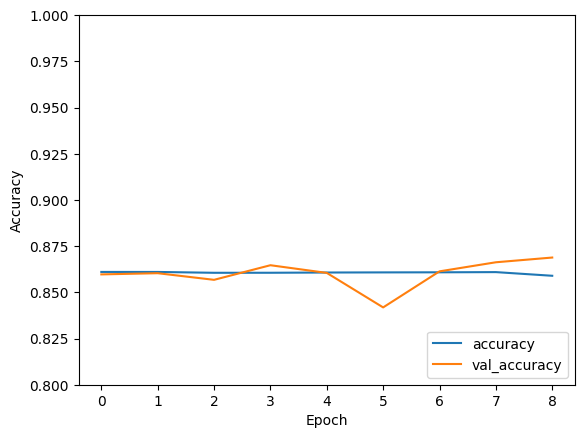

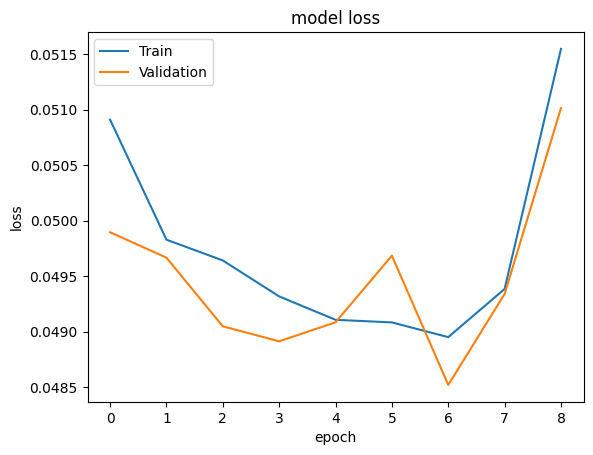

In [33]:
import matplotlib.pyplot as plt
# test the model
begin = time.time()
test_loss, test_acc, test_f1, test_precision, test_recall = model.evaluate(X_test,  Y_test, verbose=1)
end = time.time()
print(f"The testing time is {end - begin} seconds.")
# Check learning curve
# show the history of the model training
# the accuracy of the train and validation for each epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# MMDL Fusion stage

**The MMDL Fusion stage is the final stage of the MMDL pipeline. It takes the predictions of the MMDL models and combines them to produce the final prediction**

### Load the MMDL models

- [ ] Save the UNet model in keras format
- [ ] Save the LSTM model in keras format
- [ ] Perform additive fusion
- [ ] Perform multiplication fusion
- [ ] Perform Gated fusion
- [ ] Perform Nonlinear fusion

In [34]:
# Load U-Net and LSTM models
from tensorflow.keras.models import load_model

# Load the saved model
lstm_model = model
lstm_model_path = load_model('s2_multi_with_cloud_auto_labeled_50.keras')

## Perform Late Fusion using Concatenation

### Technique: Additive Fusion (Concatenation)

In [11]:
from tensorflow.keras.layers import Concatenate, Dense
from tensorflow.keras.models import Model

# Late fusion: Concatenate the outputs of the U-Net and LSTM
combined = Concatenate()([unet_model_path.output, lstm_model_path.output])
# Fully connected layers for classification
dense1 = Dense(64, activation='relu')(combined)
output = Dense(3, activation='softmax')(dense1)  # Assuming 3 classes

# Create the late fusion model
late_fusion_model = Model(inputs=[unet_model.input, lstm_model.input], outputs=output)

NameError: name 'unet_model_path' is not defined

### Technique: Multiplicative Fusion

### Technique: Gated Fusion

In [ ]:

# Load the saved U-Net and LSTM models
unet_model = load_model(unet_model_path)
lstm_model = load_model(lstm_model_path)

# Ensure both models have compatible output shapes
# If necessary, adjust the shapes (flatten, reshape) to match
unet_output = unet_model.output
lstm_output = lstm_model.output

# Create gating mechanisms for both modalities
# The gates are learned weights that control the contribution of each modality
gate_unet = Dense(unet_output.shape[-1], activation='sigmoid')(unet_output)
gate_lstm = Dense(lstm_output.shape[-1], activation='sigmoid')(lstm_output)

# Weight the original outputs by their respective gates
gated_unet_output = Multiply()([unet_output, gate_unet])
gated_lstm_output = Multiply()([lstm_output, gate_lstm])

# Combine the gated outputs
fused_output = Add()([gated_unet_output, gated_lstm_output])

# Add fully connected layers for classification after the fusion
dense1 = Dense(64, activation='relu')(fused_output)
output = Dense(3, activation='softmax')(dense1)  # Assuming 3 classes

# Create the final gated fusion model
gated_fusion_model = Model(inputs=[unet_model.input, lstm_model.input], outputs=output)

# Compile the model
gated_fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
gated_fusion_model.summary()

### Technique: Nonlinear Fusion

In [ ]:

# Load the saved U-Net and LSTM models
unet_model = load_model(unet_model_path)
lstm_model = load_model(lstm_model_path)

# Ensure both models have compatible output shapes
# If necessary, adjust the shapes (flatten, reshape) to match
unet_output = unet_model.output
lstm_output = lstm_model.output

# Nonlinear fusion: Use a neural network to learn the combination of the two modalities
# Concatenate the features from both modalities
combined_features = Concatenate()([unet_output, lstm_output])

# Pass the concatenated features through multiple dense layers to learn nonlinear interactions
fusion_layer = Dense(128, activation='relu')(combined_features)
fusion_layer = Dense(64, activation='relu')(fusion_layer)
fusion_layer = Dense(32, activation='relu')(fusion_layer)

# Final classification layer
output = Dense(3, activation='softmax')(fusion_layer)  # Assuming 3 classes

# Create the final nonlinear fusion model
nonlinear_fusion_model = Model(inputs=[unet_model.input, lstm_model.input], outputs=output)

# Compile the model
nonlinear_fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Technique: Attention-Based Mechanism